# CHECK ATTACK (PERTURBED) FILES

In [1]:
import IPython.display as ipd
import logging
import numpy as np
import librosa
from src.audio_utils import read_audio
from src.utils import *
# from sp_utils import spectrogram_inversion, get_spectrogram_from_audio
# from attacks_utils import retrieve_single_cached_spec, load_spec_model, evaluate_spec, get_pred_class
from check_attacks_utils import check_attack

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True


In [2]:
seed_everything(1234)
set_gpu(-1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
plt.style.use('dark_background')
rate = 16000

GPU selected: 0 - NVIDIA TITAN X (Pascal)


In [3]:
def compute_snr(file_number, perturbed_audio):
    clean_audio_path = f'FGSM_ResNet/FGSM_ResNet_dataset_0dot0/FGSM_ResNet_LA_E_{file_number}_0dot0.flac' 
    clean_audio, _ = librosa.load(clean_audio_path, sr=16000)
    noise = perturbed_audio - clean_audio
    signal_power = np.mean(clean_audio**2)
    noise_power = np.mean(noise**2) 
    snr = 10 * np.log10(signal_power/noise_power)
    return snr

   
def check_and_plot(eval_model, attack_model, attack, file_number, epsilon, type_of_spec, rate):
    perturbed_audio, original_audio, perturbed_spec, original_spec = check_attack(eval_model=eval_model, 
                                                                 attack_model=attack_model, 
                                                                 attack=attack, 
                                                                 file_number=file_number, 
                                                                 epsilon=epsilon,
                                                                 type_of_spec=type_of_spec,
                                                                 device=device)
    print(f'SNR: {compute_snr(file_number, perturbed_audio):.2f} dB')
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    librosa.display.specshow(original_spec, sr=rate, x_axis='time', y_axis='hz')
    if type_of_spec == 'mag':
        plt.colorbar(format='%+2.0f lin.')
    elif type_of_spec == 'pow':
        plt.colorbar(format='%+2.0f dB')
    plt.title(f'Original signal for file {file_number}')
    plt.subplot(2,1,2)
    librosa.display.specshow(perturbed_spec, sr=rate, x_axis='time', y_axis='hz')
    if type_of_spec == 'mag':
        plt.colorbar(format='%+2.0f lin.')
    elif type_of_spec == 'pow':
        plt.colorbar(format='%+2.0f dB')
    
    plt.title(f'Perturbed signal with {attack} attack on {attack_model} eps={epsilon}')
    plt.tight_layout()
    plt.show()
    
    return perturbed_audio, original_audio
    

--> File name: FGSM_SENet_LA_E_1001227_3dot0.flac
--> Model evaluated: SENet
--> Attack: FGSM on SENet
--> Epsilon: 3.0
--> GT label: 1
 --> Predicted label: 0, 
tensor([[-0.0628, -2.7990]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
--> Confidence: 93.91 %
SNR: 14.24 dB


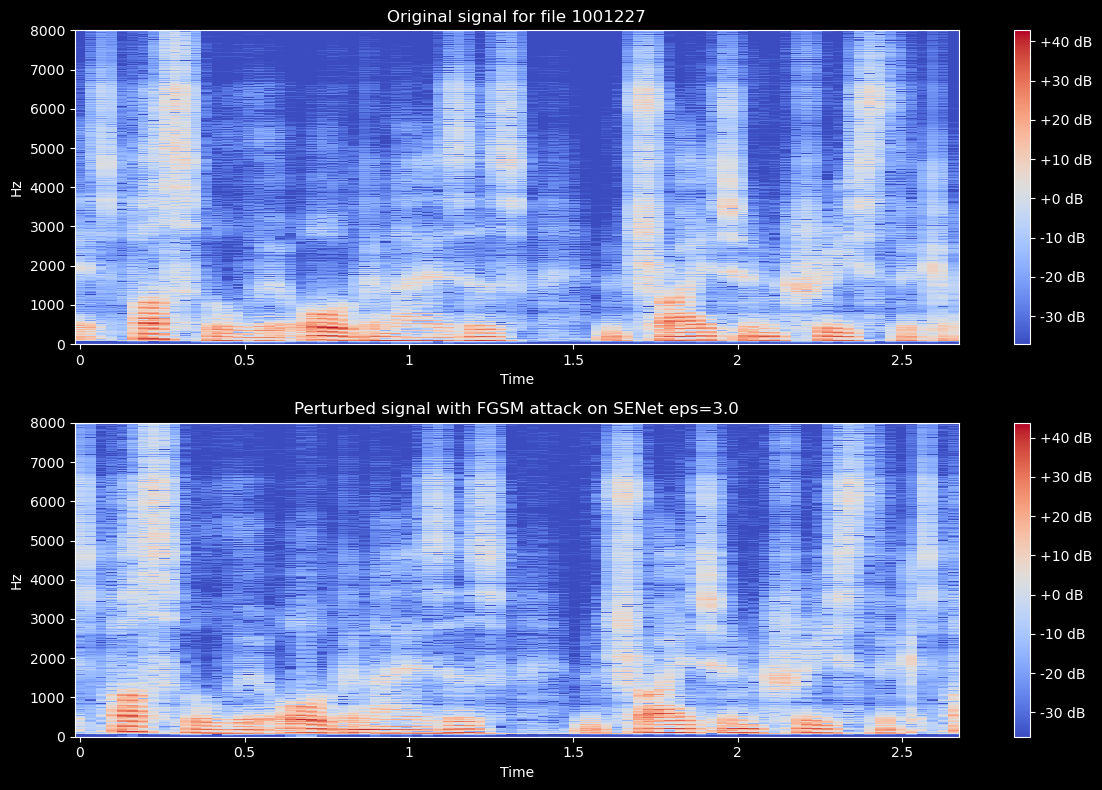

In [10]:
eval_model = 'SENet'
attack_model = 'SENet'
attack = 'FGSM'
type_of_spec = 'pow'
file_number = 1001227
epsilon = 3.0
rate = 16000
perturbed_audioB, original_audioB = check_and_plot(eval_model, attack_model, attack, file_number, epsilon, type_of_spec, rate)

In [6]:
ipd.Audio(original_audioB, rate=16000)

In [7]:
ipd.Audio(perturbed_audioB, rate=16000)

***
## Spectrogram inspections

In [13]:
from src.resnet_features import compute_spectrum
file_number = 8877452
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac'
path_to_pertspec_3dot0 = f'FGSM_3s_ResNet/FGSM_ResNet_3s_dataset_3dot0/spec/FGSM_ResNet_3s_LA_E_{file_number}_3dot0.npy'

clean_audio, _ = librosa.load(path_to_original, sr=16000)
clean_spec = compute_spectrum(x=clean_audio, type_of_spec='pow')[:,:84]
pert_spec = np.load(path_to_pertspec_3dot0)

In [1]:
y = pert_spec - clean_spec
len(y)

NameError: name 'pert_spec' is not defined

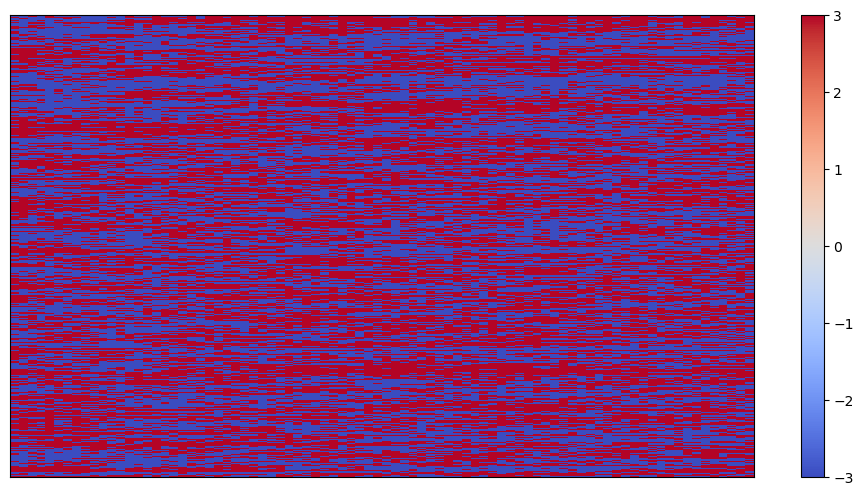

In [17]:
plt.figure(figsize=(12,6))
librosa.display.specshow(y, sr=16000)
plt.colorbar()
plt.show()